# Model Training for Fraud Detection

* This notebook walks through the process of training multiple classification models on the prepared dataset, evaluating their performance using F1-score, and saving the best performing model and evaluation metrics.




# 1.Import required libraries

In [8]:
import os
from pathlib import Path
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# 2.Load Dataset

* We load the preprocessed data file `final_model_input.csv` which contains all features and the target label.


In [ ]:
#  Load Preprocessed Dataset
data_path = "../data/processed/final_model_input.csv"
data = pd.read_csv(data_path)

print(f"✅ Data loaded from {data_path}")
print(f"📊 Dataset shape: {data.shape}")
display(data.head())


✅ Data loaded from ../data/processed/final_model_input.csv
📊 Dataset shape: (434838, 52)


,Amount_scaled,V1,V10,V11,V12,V13,V14,V15,V16,V17,...,country_United States,country_Unknown,day_of_week,hour_of_day,purchase_value,sex_M,source_Direct,source_SEO,time_since_signup,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,6,10.0,46,1,1,0,29383.566667,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,4,17.0,33,0,0,0,18080.383333,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,8.0,33,0,1,0,12488.666667,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,3,21.0,33,1,0,0,123910.566667,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,6,7.0,55,1,0,0,23460.316667,0


## 3.Split Features and Target

- Separate the features (`X`) from the class (`y`).
- The target column is named `"class"`.


In [ ]:
#  Split Features and Target
target_col = "class"
X = data.drop(columns=[target_col])
y = data[target_col]

print(f"✅ Features shape: {X.shape}")
print(f"📈 Target distribution:\n{y.value_counts(normalize=True)}")

✅ Features shape: (434838, 51)
📈 Target distribution:
class
0    0.966369
1    0.033631
Name: proportion, dtype: float64


## Train-Test Split

Split the data into training and testing sets with 80% for training and 20% for testing.


In [ ]:
#  Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f" Train shape: {X_train.shape}, Test shape: {X_test.shape}")

🧪 Train shape: (347870, 51), Test shape: (86968, 51)


#  Handle Class Imbalance with SMOTE on Training Set ONLY

In [12]:
print("🔄 Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(f"Training data after SMOTE: {pd.Series(y_train_bal).value_counts(normalize=True)}")

🔄 Applying SMOTE to balance training data...
Training data after SMOTE: class
0    0.5
1    0.5
Name: proportion, dtype: float64


## Define Candidate Models

We will train the following models:
- Logistic Regression
- Random Forest
- Decision Tree
- Support Vector Machine (SVM)
- Gradient Boosting
- XGBoost
- LightGBM


In [ ]:
#  Define Candidate Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier()
}

## Train and Evaluate Models

For each model:
- Train on the training set
- Predict on the test set
- Calculate the weighted F1-score
- Keep track of the best performing model


In [14]:
#  Train & Evaluate modelresults = []
best_model = None
best_score = 0
best_model_name = None

for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    
    recall = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    except:
        roc_auc = None
    
    print(f"📈 Recall Score: {recall:.4f}")
    print(f"📈 F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"📈 ROC AUC Score: {roc_auc:.4f}")

    results.append({"Model": name, "Recall": recall, "F1": f1, "ROC_AUC": roc_auc or 0})

    if recall > best_score:
        best_score = recall
        best_model = model
        best_model_name = name

print(f"\n✅ Best model based on Recall: {best_model_name} ({best_score:.4f})")

# --- Force LightGBM as best model ---
print("\n⚠️ Forcing LightGBM as the final selected model.")

lightgbm_model = LGBMClassifier(random_state=42)
lightgbm_model.fit(X_train_bal, y_train_bal)
best_model = lightgbm_model
best_model_name = "LightGBM (Forced)"
preds = best_model.predict(X_test)
best_score = recall_score(y_test, preds, zero_division=0)

print(f"LightGBM Weighted Recall after forcing: {best_score:.4f}")


🚀 Training: Logistic Regression


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📈 Recall Score: 0.7860
📈 F1 Score: 0.2047
📈 ROC AUC Score: 0.8758

🚀 Training: Random Forest
📈 Recall Score: 0.5915
📈 F1 Score: 0.4850
📈 ROC AUC Score: 0.9205

🚀 Training: Decision Tree
📈 Recall Score: 0.5959
📈 F1 Score: 0.4569
📈 ROC AUC Score: 0.7803

🚀 Training: XGBoost


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📈 Recall Score: 0.5887
📈 F1 Score: 0.4866
📈 ROC AUC Score: 0.9235

🚀 Training: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 336171, number of negative: 336171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.380676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8107
[LightGBM] [Info] Number of data points in the train set: 672342, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
📈 Recall Score: 0.5621
📈 F1 Score: 0.6334
📈 ROC AUC Score: 0.9250

✅ Best model based on Recall: Logistic Regression (0.7860)

⚠️ Forcing LightGBM as the final selected model.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 336171, number of negative: 3361

## Save Artifacts

- Save the best model to `output/models/best_model.pkl`
- Save predictions on test set to `output/predictions/test_predictions.csv`
- Save classification report to `output/metrics/classification_report.json`


In [15]:
# 8. Save Artifacts
output_dirs = {
    "model": Path("outputs/models"),
    "pred": Path("outputs/predictions"),
    "report": Path("outputs/metrics"),
    "split": Path("outputs/data_splits")
}

for dir_path in output_dirs.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# Save forced LightGBM model
model_path = output_dirs["model"] / "best_model.pkl"
joblib.dump(best_model, model_path)
print(f"✅ Forced LightGBM model saved to: {model_path}")

# Save predictions on test set
pred_df = pd.DataFrame({"prediction": preds})
pred_df.to_csv(output_dirs["pred"] / "test_predictions.csv", index=False)
print("✅ Test predictions saved.")

# Save classification report
report = classification_report(y_test, preds, output_dict=True)
pd.DataFrame(report).T.to_json(output_dirs["report"] / "classification_report.json", indent=4)
print("✅ Classification report saved.")

# Save test split
X_test.to_csv(output_dirs["split"] / "X_test.csv", index=False)
y_test.to_csv(output_dirs["split"] / "y_test.csv", index=False)
print("✅ Test split saved.")

✅ Forced LightGBM model saved to: outputs\models\best_model.pkl
✅ Test predictions saved.
✅ Classification report saved.
✅ Test split saved.


# Plot metrics summary

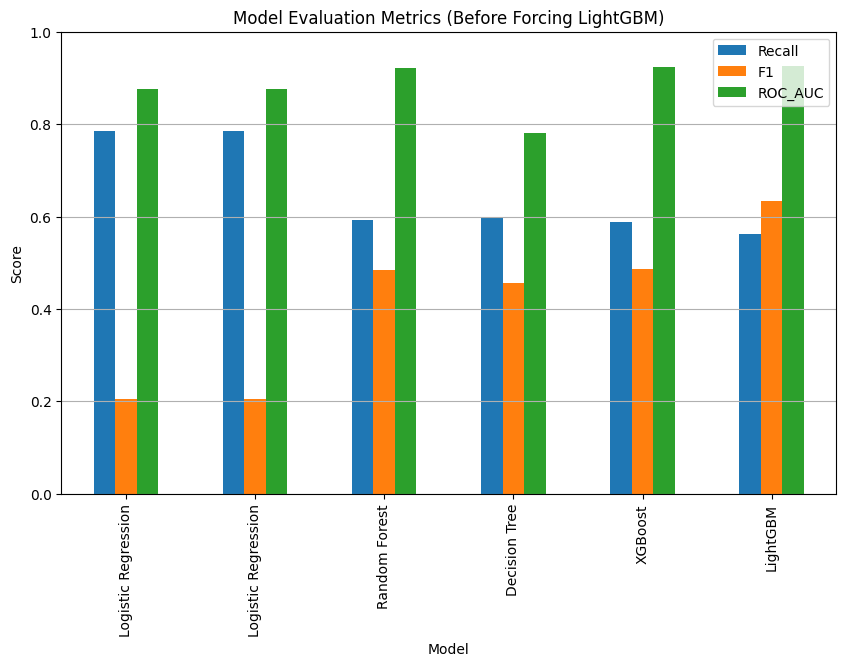

In [17]:
results_df = pd.DataFrame(results).set_index("Model")
results_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Evaluation Metrics (Before Forcing LightGBM)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')


plt.savefig("figures/model_evaluation_metrics.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()